In [7]:
import pandas as pd
import numpy as np
import os
from pandas.tseries.offsets import BDay
import pickle
import fnmatch
from scipy import stats
from pylab import *
import statsmodels as sts
import datetime as dt
import glob
from scipy.spatial.distance import pdist, squareform
def listdirs(folder): #return only directories from a master folder
    return [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

def find_path(basepath, stringname):
    for fname in os.listdir(basepath):
        path = os.path.join(basepath, fname)
        if os.path.isdir(path):
            if stringname in fname:
                return path
def get_ticket(rx_path):
    ticker=rx_path.split(".")[0].split("/")[-1].split("-")[0]
    return ticker

def ticker_trades_dir(ticker):
    dest=os.path.join(os.getenv('FINANCE_DATA'), "_".join((ticker,'trades')))
    if not os.path.isdir(dest):
        os.makedirs(dest)
def quotes_trades_dir(ticker):
    dest=os.path.join(os.getenv('FINANCE_DATA'), "_".join((ticker,'quotes')))
    if not os.path.isdir(dest):
        os.makedirs(dest)
def agg_on_trd_time(gr):
    """
    Utility func to aggregate trades on timestamp. All trades with equal time stamp
    will collapse to one row and the traded price will be the volume weighted traded
    price.
    """
    vTrdPrice = np.sum(gr['TradedPrice'] * gr['Volume'])/np.sum(gr['Volume'])
    volume = np.sum(gr['Volume'])

    return pd.Series({'Volume': volume,
                      'TradedPrice': vTrdPrice})

In [8]:
data_dir = os.getenv('FINANCE_DATA') #main directory
data_only_drive= '/mnt/usb-Seagate_Expansion_Desk_NA8XEHR6-0:0-part2'
bmrg_symbols=[s for s in os.listdir(data_dir) if s.endswith('20181028') or s.endswith('20181027')]


bmrg_symbols_destinations=[s for s in os.listdir(data_dir) if s.endswith('trades') or s.endswith('quotes')]
bmrg_tickers=[bmrg_symbols_destinations[idx].split('_t')[0] or \
              bmrg_symbols_destinations[idx].split('_q')[0] for idx,_ in enumerate(bmrg_symbols_destinations)]

In [9]:
bmrg_folders=[s for s in os.listdir(data_dir) if s.endswith('Comdty')]
bmrg_trades=[s for s in os.listdir(data_dir) if s.endswith('y_trades')]
bmrg_quotes=[s for s in os.listdir(data_dir) if s.endswith('y_quotes')]
bmrg_tickers=[bmrg_trades[idx].split('_t')[0] for idx,_ in enumerate(bmrg_trades)]

In [16]:
bmrg_tickers

['G_1_Comdty',
 'KE1_Comdty',
 'RX1_Comdty',
 'XM1_Comdty',
 'JB1_Comdty',
 'FB1_Comdty',
 'TU1_Comdty',
 'DU1_Comdty',
 'VXX_US_Equity',
 'YM1_Comdty',
 'FV1_Comdty',
 'OE1_Comdty',
 'TY1_Comdty',
 'US1_Comdty']

In [25]:
symbol='US1_Comdty'
trades_files_loc = os.path.join(data_dir,symbol)
trades_files=os.listdir(trades_files_loc)
file_idx=1
trades_df = pd.read_csv(os.path.join(trades_files_loc, trades_files[file_idx]), index_col=0)
trades_df.shape

(18302, 4)

In [47]:
trades_df['SquaredReturns']=trades_df['ReturnTradedPrice']**2

In [48]:
trades_df.fillna(value=0, inplace=True)
trades_df.columns.values


array(['TradedPrice', 'ReturnTradedPrice', 'Volume', 'Duration',
       'SquaredReturns'], dtype=object)

In [28]:

import scipy, scipy.stats, numpy as np
from scipy.spatial.distance import pdist, squareform

Text(0,0.5,'Duration')

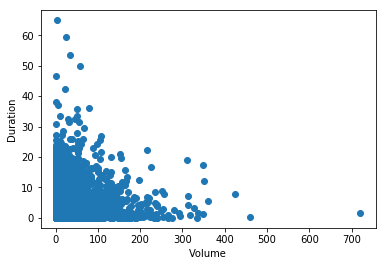

In [31]:
fig, ax = subplots()
z=trades_df[trades_df['ReturnTradedPrice']!=0]
ax.scatter(z['Volume'], z['Duration'], cmap='gray')
# ax.set_aspect(1)
# xlim(np.min(z['ReturnTradedPrice']), np.max(z['ReturnTradedPrice']))
# ylim(np.max(z['Duration']), np.max(z['Duration']))
xlabel('Volume')
ylabel('Duration')
# title('Volume') ;

In [37]:
trades_df.columns.values

array(['TradedPrice', 'ReturnTradedPrice', 'Volume', 'Duration',
       'SquaredReturns'], dtype=object)

In [46]:
trades_df['square']

,TradedPrice,ReturnTradedPrice,Volume,Duration,SquaredReturns
TradedTime,,,,,
2018-10-11 07:00:00.000,0.000000,0.000000e+00,0.0,0.000,0.000000e+00
2018-10-11 07:00:00.241,120.000000,0.000000e+00,306.0,0.241,0.000000e+00
2018-10-11 07:00:00.242,120.000000,0.000000e+00,286.0,0.001,0.000000e+00
2018-10-11 07:00:00.253,119.990000,-8.333681e-05,16.0,0.011,6.945023e-09
2018-10-11 07:00:00.269,119.980000,-8.334375e-05,5.0,0.016,6.946181e-09
2018-10-11 07:00:00.283,119.970000,-8.335070e-05,7.0,0.014,6.947339e-09
2018-10-11 07:00:00.297,119.970000,0.000000e+00,7.0,0.014,0.000000e+00
2018-10-11 07:00:00.311,119.970000,0.000000e+00,2.0,0.014,0.000000e+00
2018-10-11 07:00:00.353,119.971111,9.261532e-06,9.0,0.042,8.577597e-11


In [1]:
z['ReturnTradedPrice']

NameError: name 'z' is not defined